In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import seaborn as sns
# from cdo import *
# cdo = Cdo()

# from LinearRegression import linear_regression
dir_input = '/work/mh0033/m301036/LSAT/Data/Regrid/'

data_CRUTEMP  = dir_input+'tas_CRUTEMP_regrid.nc'
data_MLOST    = dir_input+'tas_MLOST_regrid.nc'
data_GISSTEMP = dir_input+'tas_GISS_regrid.nc'

In [2]:
#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
display(tas_MLOST.time)

tas_CRUTEMP = tas_CRUTEMP.astype(np.float64)
# display(tas_GISS)
# display(tas_CRUTEMP)
# display(tas_MLOST)
# display(tas_GHCNv4)

tas_CRUTEMP = tas_CRUTEMP-273.15
# tas_MLOST_sel = tas_MLOST_sel-273.15
tas_GISS

<xarray.DataArray 'time' (time: 2079)>
array([18262., 18293., 18321., ..., 81449., 81480., 81508.])
Coordinates:
  * time     (time) float64 1.826e+04 1.829e+04 ... 8.148e+04 8.151e+04
Attributes:
    standard_name:  time
    long_name:      Time
    bounds:         time_bnds
    units:          days since 1800-1-1 00:00:0.0
    calendar:       gregorian
    axis:           T

<xarray.Dataset>
Dimensions:  (time: 1719, lon: 180, lat: 90)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2023-03-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes: (12/13)
    CDI:            Climate Data Interface version 2.0.6 (https://mpimet.mpg....
    Conventions:    COARDS
    title:          GISS Surface Temperature Analysis (GISTEMP): 250km smooth...
    comments:       GISS Surface Temperature Analysis (GISTEMP): 250km smooth...
    platform:       Analysis
    Source:         http://data.giss.nasa.gov/gistemp/ source and http://data...
    ...             ...
    history:        Wed May 24 15:21:32 2023: cdo remapbil,r180x90 /work/mh00...
    dataset_title:  GISS Surface Temperature Analysis
    References:     https://www.psl.noaa.gov/data/gridded/data.gistemp.html
    update_date:    04/2023
    data_modified:  2023-04-13
    CDO:            Climate Data Operators version 2.0.6 (https://mpimet.mpg....

In [3]:
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=2079, freq=None)

In [4]:
tas_MLOST = tas_MLOST.assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 ...
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [5]:
#Land only dataset
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [6]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=tas_MLOST['time'], method='nearest')

# Apply the land-sea mask to the original dataset

masked_MLOST_tas = tas_MLOST.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_MLOST_tas

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) float64 1.826e+04 1.826e+04 ... nan nan
    air        (time, lat, lon) float32 -0.1726 -0.1726 -0.1726 ... nan nan nan
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [7]:
tas_GISS_annual    = tas_GISS['air'].loc['1900-01-01':'2022-12-31',0:90,:]
#xr.DataArray.transpose(tas_GISS['lat'], transpose_coords=True, missing_dims='raise').groupby('time.year').groups
tas_CRUTEMP_annual = tas_CRUTEMP['tas'].loc['1900-01-01':'2022-12-31',0:90,:]
tas_MLOST_annual   = masked_MLOST_tas['air'].loc['1900-01-01':'2022-12-31',0:90,:]
tas_GISS_annual,tas_MLOST_annual,tas_CRUTEMP_annual

(<xarray.DataArray 'air' (time: 1476, lat: 45, lon: 180)>
 [11955600 values with dtype=float32]
 Coordinates:
   * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2022-12-01
   * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
   * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
 Attributes:
     standard_name:  air_temperature_anomaly
     long_name:      Monthly Average Temperature Anomalies
     units:          degC
     precision:      2
     var_desc:       Air Temperature: 250km smoothing land only
     dataset:        GISS Surface Temperature Analysis (GISTEMP)
     level_desc:     Surface
     statistic:      Anomaly
     parent_stat:    Individual obs
     cell_methods:   time: anomaly (monthly from values)
     actual_range:   [-20.653255  20.77848 ],
 <xarray.DataArray 'air' (time: 1476, lat: 45, lon: 180)>
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [n

In [8]:
tas_GISS_ano     = tas_GISS_annual-tas_GISS_annual.mean()
tas_CRUTEMP_ano  = tas_CRUTEMP_annual-tas_CRUTEMP_annual.mean()
tas_MLOST_ano    = tas_MLOST_annual-tas_MLOST_annual.mean()

year = np.arange(1900,2023,1)
lat = tas_CRUTEMP['lat']
lon = tas_CRUTEMP['lon']
tas_CRUTEMP_ano.min().values
tas_GISS_ano.min().values

array(-21.0243969)

In [9]:
#Calculate the annual mean anomalies
tas_GISS_annual    = tas_GISS_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_CRUTEMP_annual = tas_CRUTEMP_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_MLOST_annual   = tas_MLOST_ano.mean(['lat','lon']).groupby('time.year').mean()

tas_GISS_annual.min().values

array(-1.21235836)

In [10]:
tas_GISS_JJA     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([6,7,8])]
tas_CRUTEMP_JJA  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([6,7,8])]
tas_MLOST_JJA    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([6,7,8])]

#calculate the wintertime anomalies
tas_GISS_DJF     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2022-03-01']
tas_CRUTEMP_DJF  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2022-03-01']
tas_MLOST_DJF    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2022-03-01']

In [11]:
#calculate annual mean for the time series of SAT
tas_GISS_JJA_mean = tas_GISS_JJA.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_JJA_mean)
tas_CRUTEMP_JJA_mean = tas_CRUTEMP_JJA.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_CRUTEMP_JJA_mean)
tas_MLOST_JJA_mean = tas_MLOST_JJA.mean(['lat','lon']).groupby('time.year').mean()
display(tas_MLOST_JJA_mean)

<xarray.DataArray 'air' (year: 123)>
array([-0.2903036 , -0.13940273, -0.5029307 , -0.5347631 , -0.5605573 ,
       -0.3958645 , -0.13891973, -0.72036725, -0.28831282, -0.40222666,
       -0.31557623, -0.41679668, -0.77577925, -0.58438236, -0.5059547 ,
       -0.2263608 , -0.51184   , -0.4606289 , -0.69994134, -0.3690628 ,
       -0.3228902 , -0.11458689, -0.327886  , -0.31907055, -0.33411935,
       -0.46496585, -0.3470029 , -0.19887562, -0.29791263, -0.48680422,
       -0.1268165 ,  0.22768708,  0.0375957 , -0.31962302, -0.24836655,
       -0.16154927,  0.11866897, -0.00633136, -0.0165049 ,  0.08897489,
       -0.05304862,  0.1518123 , -0.16870303, -0.09550654, -0.13285802,
       -0.05040658, -0.20598519, -0.29546127,  0.03067341, -0.27153394,
       -0.43757167, -0.08184242,  0.0310102 ,  0.2837808 ,  0.11829084,
       -0.05238472, -0.35302243, -0.04372081, -0.20633046,  0.02393835,
       -0.03701749, -0.100873  , -0.18287452, -0.1448698 , -0.36616457,
       -0.4433594 , -0.00942649, -0.23956706, -0.44087085, -0.23164894,
       -0.19938384, -0.16845067, -0.347162  ,  0.05700747, -0.20385377,
       -0.00560964, -0.38039717,  0.05429754, -0.46165082, -0.07392865,
        0.09583587,  0.3455812 , -0.11237717,  0.20624547,  0.07534073,
       -0.07831695, -0.04958166,  0.11577245,  0.5407276 ,  0.21535201,
        0.40715775,  0.54983646, -0.38357222,  0.10540345,  0.3389171 ,
        0.5642619 ,  0.15529184,  0.37196526,  1.0490322 ,  0.4588956 ,
        0.55414087,  0.8086891 ,  0.8096871 ,  0.7418039 ,  0.3527083 ,
        0.7966377 ,  0.86660165,  0.8922499 ,  0.7574218 ,  0.61899215,
        1.1972375 ,  1.0771083 ,  1.3327328 ,  0.8319742 ,  0.8688815 ,
        1.025936  ,  1.3496755 ,  1.0632602 ,  1.0328745 ,  1.1903987 ,
        1.2113911 ,  1.4605073 ,  1.371122  ], dtype=float32)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022

In [12]:
# time_series_GISS_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GISS_JJA_mean})
# time_series_GISS_JJA.to_csv('GISS_JJA_NH.txt', sep='\t', index=False)

# time_series_CRUTEMP_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_CRUTEMP_JJA_mean})
# time_series_CRUTEMP_JJA.to_csv('CRUTEMP_JJA_NH.txt', sep='\t', index=False)

# time_series_GHCNv4_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GHCNv4_JJA_mean})
# time_series_GHCNv4_JJA.to_csv('GHCNv4_JJA_NH.txt', sep='\t', index=False)

# time_series_MLOST_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_MLOST_JJA_mean})
# time_series_MLOST_JJA.to_csv('MLOST_JJA_NH.txt', sep='\t', index=False)

In [13]:
#calculate DJF mean for the time series of SAT
tas_GISS_DJF_mean = tas_GISS_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_DJF_mean)
tas_CRUTEMP_DJF_mean = tas_CRUTEMP_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_CRUTEMP_DJF_mean)
tas_MLOST_DJF_mean = tas_MLOST_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_MLOST_DJF_mean)

In [14]:
#Calculate the 15yr running trend time series
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the window size (35 years)
window_size = 35

# Calculate the number of data points in the window
num_points  = len(tas_GISS_annual)
num_windows = num_points - window_size + 1

# Initialize an array to store the trend values
trend = np.zeros(num_windows)
for i in range(num_windows):
    GISS_window_data = tas_GISS_annual[i:i+window_size]
    time = np.arange(len(GISS_window_data))
    trend[i] = np.polyfit(time, GISS_window_data, 1)[0]

print(trend)
print(len(trend))

trend1 = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_data = tas_MLOST_annual[i:i+window_size]
    time = np.arange(len(MLOST_window_data))
    trend1[i] = np.polyfit(time, MLOST_window_data, 1)[0]

print(trend1)
print(len(trend1))

[ 0.01260781  0.01414613  0.01635878  0.01722446  0.02081087  0.02216685
  0.02308646  0.02373108  0.0221497   0.02370308  0.02448631  0.02429137
  0.02331314  0.02156144  0.02167495  0.02205948  0.02019758  0.01789762
  0.01366904  0.01337928  0.01058311  0.0085126   0.00676636  0.00498738
  0.00387125  0.00340892  0.00332738  0.00347479  0.00255101  0.00162757
 -0.0035877  -0.00564755 -0.00745632 -0.00730175 -0.01102005 -0.01149875
 -0.01255889 -0.01315984 -0.01364666 -0.00992942 -0.00955489 -0.00826782
 -0.01027326 -0.0091683  -0.00694782 -0.00501338 -0.00382207 -0.0002628
  0.00049316  0.00383505  0.00496646  0.00428639  0.00508726  0.00552033
  0.0102074   0.01272647  0.0152523   0.01576312  0.01542907  0.01600861
  0.0182845   0.02233746  0.02333786  0.02636301  0.02949536  0.0297466
  0.03020928  0.03102197  0.03363442  0.03475811  0.0338391   0.03592881
  0.03737002  0.03780138  0.03906282  0.03742464  0.03931394  0.03839915
  0.03909346  0.03783925  0.03653926  0.03766167  0.0

In [15]:
trend2 = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_data = tas_CRUTEMP_annual[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_data))
    trend2[i] = np.polyfit(time, CRUTEMP_window_data, 1)[0]

print(trend2)
print(len(trend2))

[ 0.00936354  0.01093839  0.01288071  0.01129308  0.01422775  0.01491823
  0.01375853  0.01401167  0.0110343   0.01189244  0.01267902  0.01274302
  0.01255708  0.00961803  0.01110512  0.01222352  0.01010568  0.00902054
  0.00451115  0.00533119  0.00252359  0.00182906  0.00123245  0.00050937
  0.00036737 -0.00038591  0.00025949  0.00093737  0.00103116  0.00121183
 -0.0030997  -0.00350208 -0.00397879 -0.00314854 -0.006151   -0.00593776
 -0.00609637 -0.00605933 -0.00746479 -0.00362865 -0.00254585 -0.00193663
 -0.0045746  -0.00461647 -0.00270498 -0.00079503 -0.00098766  0.00224586
  0.00228646  0.0065139   0.00688307  0.00491947  0.00604532  0.00599428
  0.01041464  0.01256892  0.01547446  0.01525573  0.01560096  0.01594796
  0.01814021  0.02127258  0.02185579  0.02496541  0.02878601  0.02987341
  0.03027928  0.03146052  0.03419819  0.03499568  0.03371     0.03495075
  0.03568506  0.03645367  0.03816655  0.03593734  0.03671098  0.0345651
  0.03429833  0.03335738  0.0320471   0.03381029  0.

In [16]:
#Calculate JJA and DJF trend
trend_JJA = np.zeros(num_windows)
for i in range(num_windows):
    GISS_window_jja = tas_GISS_JJA_mean[i:i+window_size]
    time = np.arange(len(GISS_window_jja))
    trend_JJA[i] = np.polyfit(time, GISS_window_jja, 1)[0]

print(trend_JJA)
print(len(trend_JJA))

trend_DJF = np.zeros(num_windows)
for i in range(num_windows):
    GISS_window_djf = tas_GISS_DJF_mean[i:i+window_size]
    time = np.arange(len(GISS_window_djf))
    trend_DJF[i] = np.polyfit(time, GISS_window_djf, 1)[0]

print(trend_DJF)
print(len(trend_DJF))

[ 0.00796817  0.00954119  0.01410758  0.01472296  0.0152594   0.01509924
  0.01604856  0.01837088  0.01678073  0.01680059  0.01639477  0.01626079
  0.01627932  0.01354377  0.01213442  0.01052652  0.00912523  0.00765517
  0.00734426  0.00729557  0.00692605  0.0066052   0.00555321  0.0055584
  0.00403336  0.00371241  0.00383113  0.00271771  0.00196169 -0.00028267
 -0.00342132 -0.00487821 -0.00360306 -0.00413995 -0.00628378 -0.00730486
 -0.00771557 -0.00678601 -0.00661132 -0.00438229 -0.00369524 -0.00270224
 -0.00294942 -0.00189653 -0.0026137  -0.00233969 -0.0010682   0.00038304
 -0.00014856  0.00179946  0.00161631  0.00041875  0.00028243  0.00150309
  0.00594184  0.00832348  0.01123226  0.01256728  0.01139694  0.0115876
  0.01409535  0.01760301  0.0184961   0.01957006  0.02300898  0.02318385
  0.02304299  0.02579598  0.02765062  0.0281688   0.02756731  0.02904797
  0.03059079  0.03113261  0.03245006  0.03188398  0.03402646  0.03362488
  0.03587204  0.03410227  0.03307956  0.0329752   0.0

In [17]:
trend1_JJA = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_jja = tas_MLOST_JJA_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_jja))
    trend1_JJA[i] = np.polyfit(time, MLOST_window_jja, 1)[0]

print(trend1_JJA)
print(len(trend1_JJA))

trend1_DJF = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_djf = tas_MLOST_DJF_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_djf))
    trend1_DJF[i] = np.polyfit(time, MLOST_window_djf, 1)[0]

print(trend1_DJF)
print(len(trend1_DJF))

[ 7.91196602e-03  9.17577741e-03  1.24987404e-02  1.33212606e-02
  1.37957324e-02  1.44972637e-02  1.51709348e-02  1.80196271e-02
  1.63289500e-02  1.70107257e-02  1.68862743e-02  1.75158884e-02
  1.68200194e-02  1.38290270e-02  1.32215403e-02  1.13981201e-02
  1.01280970e-02  9.17179465e-03  8.89064536e-03  8.46883427e-03
  8.65171837e-03  8.11815117e-03  7.12747278e-03  6.60099027e-03
  5.26502557e-03  4.91812285e-03  3.52092769e-03  2.29455640e-03
  1.35561796e-03  9.38259870e-05 -3.21701427e-03 -5.11417749e-03
 -3.06891306e-03 -3.01158159e-03 -5.63630582e-03 -6.87149591e-03
 -7.51999130e-03 -6.59772290e-03 -7.07628898e-03 -5.58606284e-03
 -4.82679396e-03 -3.75756548e-03 -3.45341556e-03 -2.54625623e-03
 -3.78940106e-03 -3.27201520e-03 -1.54701212e-03  5.41860197e-04
 -1.55661951e-04  2.25715901e-03  2.47370976e-03  1.02422841e-03
  1.40454311e-03  3.13222649e-03  8.13423664e-03  1.06804621e-02
  1.32523110e-02  1.48590387e-02  1.33275655e-02  1.33998637e-02
  1.56578305e-02  1.85932

In [18]:
trend2_JJA = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_jja = tas_CRUTEMP_JJA_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_jja))
    trend2_JJA[i] = np.polyfit(time, CRUTEMP_window_jja, 1)[0]

print(trend2_JJA)
print(len(trend2_JJA))

trend2_DJF = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_djf = tas_CRUTEMP_DJF_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_djf))
    trend2_DJF[i] = np.polyfit(time, CRUTEMP_window_djf, 1)[0]

print(trend2_DJF)
print(len(trend2_DJF))

[ 0.01036803  0.01259005  0.01990123  0.02061306  0.02126287  0.02088942
  0.02218992  0.02335052  0.02070456  0.01981928  0.01853518  0.01761315
  0.01795234  0.01557526  0.0139281   0.01275282  0.00899344  0.00673074
  0.00758381  0.00674835  0.0059645   0.00511738  0.00361099  0.00312493
 -0.00024372 -0.00128274 -0.00155935 -0.00354656 -0.00453661 -0.00802412
 -0.01045032 -0.01134104 -0.01007255 -0.01020346 -0.01193735 -0.0125489
 -0.01273265 -0.01160838 -0.00994852 -0.00740969 -0.00607505 -0.00531788
 -0.0061663  -0.00546061 -0.0062274  -0.006043   -0.00519262 -0.0032799
 -0.00357774 -0.00147069 -0.00176233 -0.00300376 -0.00260384 -0.00088415
  0.00405785  0.00627022  0.0090043   0.01034535  0.00888202  0.00832838
  0.01132632  0.01410629  0.01544041  0.01668172  0.02112817  0.02224928
  0.02297618  0.02613456  0.02824488  0.02865515  0.02764065  0.02938185
  0.03086212  0.03238921  0.03365187  0.03241392  0.03507162  0.03451815
  0.0367449   0.03517282  0.03405138  0.03393739  0.0

In [19]:
# time_series_GISS_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GISS_DJF_mean})
# time_series_GISS_DJF.to_csv('GISS_DJF_NH.txt', sep='\t', index=False)

# time_series_CRUTEMP_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_CRUTEMP_DJF_mean})
# time_series_CRUTEMP_DJF.to_csv('CRUTEMP_DJF_NH.txt', sep='\t', index=False)

# time_series_GHCNv4_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GHCNv4_DJF_mean})
# time_series_GHCNv4_DJF.to_csv('GHCNv4_DJF_NH.txt', sep='\t', index=False)

# time_series_MLOST_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_MLOST_DJF_mean})
# time_series_MLOST_DJF.to_csv('MLOST_DJF_NH.txt', sep='\t', index=False)

In [20]:
len(np.arange(1917,2006,1))

89

In [21]:
out_dir = "/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/"
trend_GISS_annual = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend})
trend_GISS_annual.to_csv(out_dir+'GISS_annual_NH_35yr_trend.txt', sep='\t', index=False)

trend_GISS_JJA = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend_JJA})
trend_GISS_JJA.to_csv(out_dir+'GISS_JJA_NH_35yr_trend.txt', sep='\t', index=False)

trend_GISS_DJF = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend_DJF})
trend_GISS_DJF.to_csv(out_dir+'GISS_DJF_NH_35yr_trend.txt', sep='\t', index=False)

In [22]:
trend_MLOST_annual = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend1})
trend_MLOST_annual.to_csv(out_dir+'MLOST_annual_NH_35yr_trend.txt', sep='\t', index=False)

trend_MLOST_JJA = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend1_JJA})
trend_MLOST_JJA.to_csv(out_dir+'MLOST_JJA_NH_35yr_trend.txt', sep='\t', index=False)

trend_MLOST_DJF = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend1_DJF})
trend_MLOST_DJF.to_csv(out_dir+'MLOST_DJF_NH_35yr_trend.txt', sep='\t', index=False)

In [23]:
trend_CRUTEMP_annual = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend2})
trend_CRUTEMP_annual.to_csv(out_dir+'CRUTEMP_annual_NH_35yr_trend.txt', sep='\t', index=False)

trend_CRUTEMP_JJA = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend2_JJA})
trend_CRUTEMP_JJA.to_csv(out_dir+'CRUTEMP_JJA_NH_35yr_trend.txt', sep='\t', index=False)

trend_CRUTEMP_DJF = pd.DataFrame({'time': np.arange(1917,2006,1), 'values': trend2_DJF})
trend_CRUTEMP_DJF.to_csv(out_dir+'CRUTEMP_DJF_NH_35yr_trend.txt', sep='\t', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

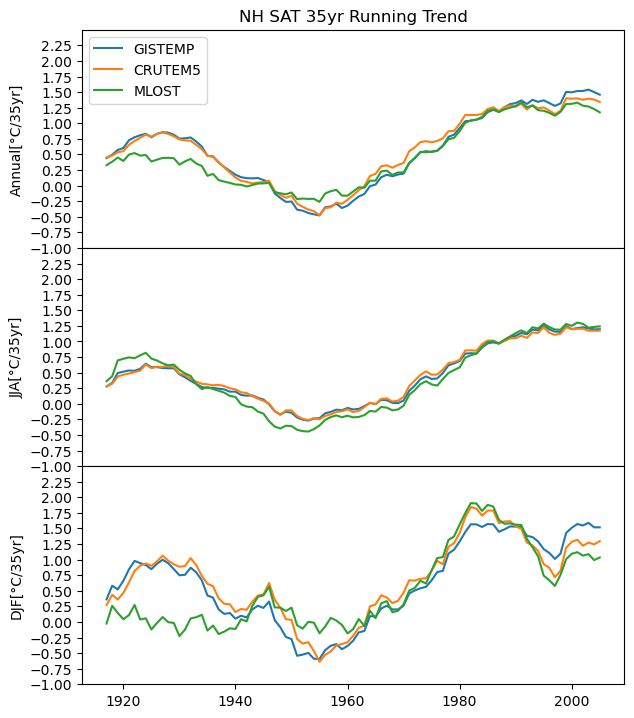

In [26]:
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
# plt.style.use('seaborn-bright')
x = np.arange(1917,2006,1)

axs[0].plot(x, trend*35.0, label='GISTEMP')
axs[0].plot(x, trend1*35.0, label='CRUTEM5')
axs[0].plot(x, trend2*35.0, label='MLOST')

axs[0].set_ylabel("Annual[°C/35yr]")
axs[0].set_title('NH SAT 35yr Running Trend')

axs[1].plot(x, trend_JJA*35.0)
axs[1].plot(x, trend1_JJA*35.0)
axs[1].plot(x, trend2_JJA*35.0)
# axs[1].plot(x, tas_GHCNv4_JJA_mean)
axs[1].set_ylabel("JJA[°C/35yr]")
# axs[1].set_title('1900-2014 JJA NH SAT')

axs[0].set_yticks(np.arange(-1.0,2.5, 0.25))
axs[0].set_ylim(-1.0,2.5)

axs[2].plot(x, trend_DJF*35.0)
axs[2].plot(x, trend1_DJF*35.0)
axs[2].plot(x, trend2_DJF*35.0)
# axs[2].plot(x, tas_GHCNv4_DJF_mean)
axs[2].set_ylabel("DJF[°C/35yr]")

# axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 0.95, 0.15, 0.15))
axs[0].legend()

# axs[2].set_title('1900-2014 DJF NH SAT')

# Temperature vs time plot - illustrates the "x" and "add_legend" kwargs
# air.isel(lon=30, lat=isel_lats).plot.line(ax=ax2, x="time", add_legend=False)
# ax2.set_ylabel("")
# sns.set_context('poster')

# fig.savefig("Obs_NH_15yr_SAT_trend.png")
fig.savefig('./Obs_NH_35yr_SAT_trend.png', format='png')
plt.show
# fig.tight_layout()